# Dataset inspection

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

%cd /mnt/d/Christiano/Documentos/dissertation/projeto/experiment

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.
/mnt/d/Christiano/Documentos/dissertation/projeto/experiment


## Analysing and removing careless or biased participations

We created "Dummy tasks", randomly selected code components not affected by any of the code smells considered in our study. This was done to limit the bias in the study, i.e., avoid that participants always indicate that the code contains a problem.
So, we first look for participants that accomplish tasks in a careless and/or biased way, analysing how they performed tasks when faced with dummy tasks. For instance, we intentionally created a dummy task that defines a god class, however the correspondent java code have just few line of codes. Thus, we expected that the participant would mark "I strongly disagree" or, at minimun, "I Slightly disagree". After data inspection, we noted that almost all of the participant not behave biased ou carelessly. Except for 1 participant, all of them marks some degree of disagreement when evaluated dummy tasks.

In [2]:
headerParticipant = ["inviteId","codeRevision","codeSmellIdentification","degree","devExperience", "javaExperience","objOrientedExperience","origin","yearsDevExperience"]
headerQuestionnaire = ["dtStartTasks","dtEndTasks"]
headerAnswer = ["id","questionnaire_id","task_id","secondsToAnswer","isDt","answer_ptr_id","answer_csagreement","answer_description","answer_dtDescription"]
answer =  pd.read_csv('/mnt/d/Christiano/Documentos/dissertation/projeto/experiment/participant_answer.csv', header=None, escapechar="\\", encoding="latin_1")
answer.columns=headerParticipant+headerQuestionnaire+headerAnswer

dummy_id = "13,14,15,16"
answer_dummy = answer.query("task_id in ({0})".format(dummy_id))

# o questionnaire id 25 será retirado
#answer_dummy[answer_dummy.questionnaire_id==25].loc[:,'id':'answer_csagreement']

In [3]:
# retira as atividades dummy
answer_no_dummy = answer[~answer.id.isin(answer_dummy.id)]


# X participantes x 8 atividades = Y rows
answer_no_dummy.head()

,inviteId,codeRevision,codeSmellIdentification,degree,devExperience,javaExperience,objOrientedExperience,origin,yearsDevExperience,dtStartTasks,dtEndTasks,id,questionnaire_id,task_id,secondsToAnswer,isDt,answer_ptr_id,answer_csagreement,answer_description,answer_dtDescription
0,0903fe3e42,2,1,B,2,3,2,A,2,2020-01-10 15:53:00.525442,2020-01-10 16:18:59.338721,102,16,3,119.14,1,102,2,The class is big and have too much code and va...,none
1,0903fe3e42,2,1,B,2,3,2,A,2,2020-01-10 15:53:00.525442,2020-01-10 16:18:59.338721,103,16,11,169.35,1,103,1,"It does have a long parameter list, could be a...","Helped me to see the number of statements, inp..."
2,0903fe3e42,2,1,B,2,3,2,A,2,2020-01-10 15:53:00.525442,2020-01-10 16:18:59.338721,104,16,7,250.75,1,104,1,The child class uses few methods from parent.,Helped me to identify why it was a refused beq...
3,0903fe3e42,2,1,B,2,3,2,A,2,2020-01-10 15:53:00.525442,2020-01-10 16:18:59.338721,105,16,4,235.66,1,105,-1,"It does too much in just one method, could be ...",helped me to identify where to search
8,0903fe3e42,2,1,B,2,3,2,A,2,2020-01-10 15:53:00.525442,2020-01-10 16:18:59.338721,110,16,8,42.01,0,110,2,The class is really long and implements too mu...,NaN


# Experiment results

In [4]:
import  statsmodels.stats.inter_rater as ir

def buildKappaTable(answer):    
    # calcula os agreements agrupando por atividade e agreement
    df_count_agreement = answer[['task_id','answer_csagreement']].groupby(['task_id','answer_csagreement']).size().reset_index(name='size')

    list_count_agreement = list()
    tasks = answer_no_dummy.task_id.unique()
    df_agreement_frame = pd.DataFrame([[-2,0],[-1,0],[1,0],[2,0]], columns=['answer_csagreement', 'size'])

    for task in tasks:
        df_tmp = df_count_agreement[df_count_agreement.task_id==task].iloc[:,1:3]
        df_merged = pd.merge_ordered(df_tmp, df_agreement_frame, fill_method='ffill', right_by="answer_csagreement", how="left")        
        list_count_agreement.append(df_merged['size'].tolist()) 
        
    # soma os agreements similares - agreement ou disagreement
    df_kappaTable = pd.DataFrame(list_count_agreement)
    df_disagree = df_kappaTable[0]+df_kappaTable[1]
    df_agree = df_kappaTable[2]+df_kappaTable[3]

    df_kappaTable = pd.concat([df_disagree, df_agree], axis=1)
    df_kappaTable.columns = ["Disagree", "Agree"]   
    df_kappaTable.index = tasks

    return df_kappaTable

def getFormattedTable(df_kappaTable):
    #relação de code smells e o código das atividades
    df_codeSmells = pd.DataFrame([[3,4,5,6,7,8,11,12],['gc','lm','rb','lm','rb','gc','lpl','lpl'],[1,1,2,2,1,2,1,2]])
    df_codeSmells = df_codeSmells.T
    df_codeSmells.columns = ['Task ID','CS','Task Group']    
    df_kappaTable_formatted = pd.merge(df_kappaTable,df_codeSmells,left_index=True,right_on='Task ID')
    # reordena as colunas
    df_kappaTable_formatted = df_kappaTable_formatted[['Task Group','Task ID','CS','Disagree','Agree']]
    #reordena as linhas por CS
    df_kappaTable_formatted = df_kappaTable_formatted.sort_values(['Task Group','CS'])
    return df_kappaTable_formatted

def build(answer):
    answer_dt = answer[answer.isDt==1]
    answer_noDt = answer[answer.isDt==0]
       
    df_kappaTable_dt = buildKappaTable(answer_dt)
    df_kappaTable_noDt = buildKappaTable(answer_noDt)
    #display(df_kappaTable_dt)
    #display(df_kappaTable_noDt)
    # display(df_kappaTable_dt.iloc[4:,])
    # display(df_kappaTable_noDt.iloc[4:,])

    # cálculo do fleiss kappa - participantes P1
    kappa_value_p1_dt = ir.fleiss_kappa(df_kappaTable_dt.iloc[0:4,], method='fleiss')
    kappa_value_p1_noDt = ir.fleiss_kappa(df_kappaTable_noDt.iloc[4:,], method='fleiss')

    # cálculo do fleiss kappa - participantes P2
    kappa_value_p2_dt = ir.fleiss_kappa(df_kappaTable_dt.iloc[4:,], method='fleiss')
    kappa_value_p2_noDt = ir.fleiss_kappa(df_kappaTable_noDt.iloc[0:4,], method='fleiss')    

    df_kappa_values =  pd.DataFrame([[kappa_value_p1_dt, kappa_value_p2_dt],[kappa_value_p2_noDt, kappa_value_p1_noDt]]
                                        ,columns=['Task_Group_1','Task_Group_2'], index=['DT','noDT'])
    
    df_kappa_values['Avg'] = (df_kappa_values['Task_Group_1']+df_kappa_values['Task_Group_2'])/2

    g1 = [3,4,11,7] # o grupo de task determina se o participante foi P1 ou P2
    g2 = [8,6,12,5]
    eval_matrix_p1_dt = buildEvaluationMatrix(answer_dt, g1)
    eval_matrix_p2_dt = buildEvaluationMatrix(answer_dt, g2)
    eval_matrix_p1_noDt = buildEvaluationMatrix(answer_noDt, g2)
    eval_matrix_p2_noDt = buildEvaluationMatrix(answer_noDt, g1)    
    # eval_matrix_p2_dt = buildEvaluationMatrix(answer_dt)
    # eval_matrix_p2_nodt = buildEvaluationMatrix(answer_noDt)

    return getFormattedTable(df_kappaTable_dt), getFormattedTable(df_kappaTable_noDt), df_kappa_values.round(3), eval_matrix_p1_dt, eval_matrix_p2_dt, eval_matrix_p1_noDt, eval_matrix_p2_noDt

# cria a matriz de evaluations
def buildEvaluationMatrix(answers_param, tasks):        
    # filtra apenas os evaluations de um determinado grupo de task: determina se o participante foi P1 ou P2
    answers = answers_param.query('task_id in {}'.format(tasks))
    
    #substitui -2 e -1 por 1 e 2 e 1 por 1
    answers.loc[answers.answer_csagreement.isin([2,1]),'answer_csagreement'] = 1
    answers.loc[answers.answer_csagreement.isin([-2,-1]),'answer_csagreement'] = 0
    
    answers = answers.loc[:,["task_id","questionnaire_id","answer_csagreement"]]

    answers = answers.sort_values("questionnaire_id")
        
    # percorre cada tarefa para criar a evaluation matrix
    evaluationMatrix = pd.DataFrame()
    for task_id in tasks:
        answer_aux = answers.loc[answers_param.task_id==task_id,]
        answer_aux = answer_aux.pivot(index="task_id",columns="questionnaire_id", values="answer_csagreement")
        answer_aux.columns = range(1,answer_aux.columns.size+1)        
        evaluationMatrix = pd.concat([evaluationMatrix, answer_aux])
    
    return evaluationMatrix



In [37]:
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        width = rect.get_width()        
        ax.annotate('{}'.format(width),
                    xy=(width, rect.get_y() + height / 2),
                    xytext=(15, -6),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def plotBarh(not_overall ,overall, legend):
    labels = ['DT', 'No DT']
    
    x = np.arange(len(labels))  # the label locations
    width = 0.30  # the width of the bars

    fig, ax = plt.subplots(figsize=(7, 3))
    rects1 = ax.barh(x - width/2, not_overall, width, alpha=0.6, color='#0f0f0f80', label='Overall')
    rects2 = ax.barh(x + width/2, overall, width, alpha=0.6, color='#808080', label=legend)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Agreement score')
    #ax.set_title('Scores by group and gender')
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.legend()
    ax.set_xlim([0,0.2])
#     ax.xaxis.grid(True)
#     ax.set_axisbelow(True) 

    autolabel(rects1, ax)
    autolabel(rects2, ax)
    
    fig.tight_layout()
    plt.show()
    

# Overall Agreement

In [6]:

# retira alguns participantes para equalizar o quadrado latino
#answer_no_dummy_overall = answer_no_dummy[~answer_no_dummy.questionnaire_id.isin([50,68,55,25])]
#answer_no_dummy_overall = answer_no_dummy[~answer_no_dummy.questionnaire_id.isin([50,49])] 
answer_no_dummy_overall = answer_no_dummy.copy()

df_kappaTable_dt, df_kappaTable_noDt, df_kappa_overall, eval_matrix_p1_dt, eval_matrix_p2_dt, eval_matrix_p1_noDt, eval_matrix_p2_noDt = build(answer_no_dummy_overall)

#exporta a matriz de evaluations em csv
eval_matrix_p1_dt.to_csv("csv_evaluation_matrix/overall_agreement_eval_matrix_p1_dt.csv", header=False, index=False)
eval_matrix_p2_dt.to_csv("csv_evaluation_matrix/overall_agreement_eval_matrix_p2_dt.csv", header=False, index=False)
eval_matrix_p1_noDt.to_csv("csv_evaluation_matrix/overall_agreement_eval_matrix_p1_noDt.csv", header=False, index=False)
eval_matrix_p2_noDt.to_csv("csv_evaluation_matrix/overall_agreement_eval_matrix_p2_noDt.csv", header=False, index=False)

/home/christiano/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### DT
---

In [7]:
display(eval_matrix_p1_dt)

# #tabelas formatadas com os agrees e disagrees
display(df_kappaTable_dt)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
task_id,,,,,,,,,,,,,,
3,1,1,1,1,1,1,1,1,1,0,1,1,1,1
4,0,1,1,1,1,1,1,1,1,1,1,1,1,1
11,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,1,0,0,1,0,1,1,1,1,1


,Task Group,Task ID,CS,Disagree,Agree
0,1,3,gc,1,13
1,1,4,lm,1,13
6,1,11,lpl,0,14
4,1,7,rb,5,9
5,2,8,gc,2,14
3,2,6,lm,2,14
7,2,12,lpl,7,9
2,2,5,rb,8,8


### No DT
___

In [8]:
# print("## no DT")
display(df_kappaTable_noDt)

,Task Group,Task ID,CS,Disagree,Agree
0,1,3,gc,2,14
1,1,4,lm,0,16
6,1,11,lpl,5,11
4,1,7,rb,4,12
5,2,8,gc,1,13
3,2,6,lm,3,11
7,2,12,lpl,7,7
2,2,5,rb,5,9


,Task_Group_1,Task_Group_2,Avg
DT,0.108,0.087,0.098
noDT,0.041,0.058,0.049


,0,1
0,0.0388,0.0573
1,0.3660,0.2710


(0, 0.2)

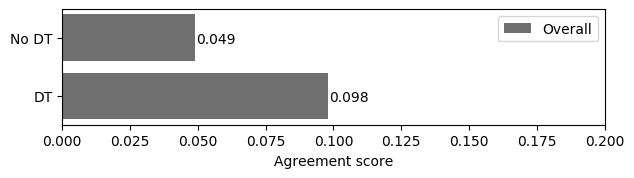

In [48]:
display(df_kappa_overall)

display(pd.DataFrame([[0.0388,0.0573],[0.366,0.271]])) #p-values

labels = ['DT', 'No DT']
    
y = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(figsize=(7, 1.5))
rects1 = ax.barh(y, df_kappa_overall.Avg, alpha=0.6, color='#0f0f0f80', label='Overall')

for rect in rects1:
    height = rect.get_height()
    width = rect.get_width()   
    ax.annotate('{}'.format(width),
                        xy=(width, rect.get_y() + height / 2),
                        xytext=(15, -6),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Agreement score')
#ax.set_title('Scores by group and gender')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.legend()
ax.set_xlim([0,0.2])

## Background: Academy

In [10]:
answer_no_dummy_academy= answer_no_dummy[answer_no_dummy.origin=="A"]

# retira alguns participantes para equalizar o quadrado latino
#answer_no_dummy_academy= answer_no_dummy_academy[~answer_no_dummy_academy.inviteId.isin(['aadeab9473','a4fdb1f70d','a4d316213a','98ade17f7a','9247fa543f'])]

df_kappaTable_dt, df_kappaTable_noDt, df_kappa_academy, eval_matrix_p1_dt, eval_matrix_p2_dt, eval_matrix_p1_noDt, eval_matrix_p2_noDt = build(answer_no_dummy_academy)

#exporta a matriz de evaluations em csv
eval_matrix_p1_dt.to_csv("csv_evaluation_matrix/academy_agreement_eval_matrix_p1_dt.csv", header=False, index=False)
eval_matrix_p2_dt.to_csv("csv_evaluation_matrix/academy_agreement_eval_matrix_p2_dt.csv", header=False, index=False)
eval_matrix_p1_noDt.to_csv("csv_evaluation_matrix/academy_agreement_eval_matrix_p1_noDt.csv", header=False, index=False)
eval_matrix_p2_noDt.to_csv("csv_evaluation_matrix/academy_agreement_eval_matrix_p2_noDt.csv", header=False, index=False)

### DT
___

In [11]:
df_kappaTable_dt

,Task Group,Task ID,CS,Disagree,Agree
0,1,3,gc,1,7
1,1,4,lm,1,7
6,1,11,lpl,0,8
4,1,7,rb,1,7
5,2,8,gc,1,12
3,2,6,lm,2,11
7,2,12,lpl,6,7
2,2,5,rb,7,6


### No DT
---

In [12]:
df_kappaTable_noDt

,Task Group,Task ID,CS,Disagree,Agree
0,1,3,gc,1,12
1,1,4,lm,0,13
6,1,11,lpl,5,8
4,1,7,rb,3,10
5,2,8,gc,1,7
3,2,6,lm,3,5
7,2,12,lpl,3,5
2,2,5,rb,2,6


### Kappa
___

,Task_Group_1,Task_Group_2,Avg
DT,-0.103,0.112,0.004
noDT,0.082,-0.082,-0.000


,0,1
0,0.274,0.0474
1,0.366,0.2710


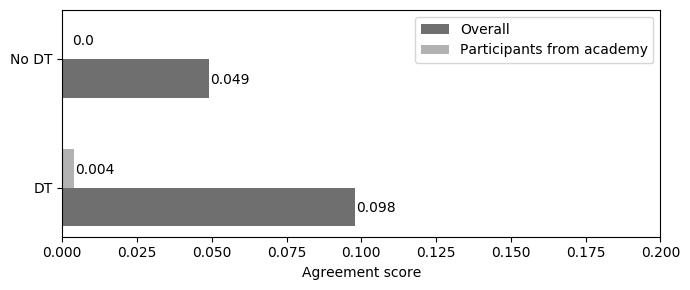

None

In [38]:
display(df_kappa_academy)

display(pd.DataFrame([[0.274,0.0474],[0.366,0.271]])) #p-values

display(plotBarh(df_kappa_overall.Avg,df_kappa_academy.Avg,'Participants from academy'))


## Background: both

In [14]:
answer_no_dummy_both= answer_no_dummy[answer_no_dummy.origin=="B"]

# retira alguns participantes para equalizar o quadrado latino
#answer_no_dummy_both = answer_no_dummy_both[~answer_no_dummy_both.inviteId.isin(['bf322c7997','96c5de2c36','902c0c14b5','a7dd78e40e'])]

df_kappaTable_dt, df_kappaTable_noDt, df_kappa_values, eval_matrix_p1_dt, eval_matrix_p2_dt, eval_matrix_p1_noDt, eval_matrix_p2_noDt = build(answer_no_dummy_both)

#exporta a matriz de evaluations em csv
#eval_matrix_dt.to_csv("csv_evaluation_matrix/both_agreement_eval_matrix_DT.csv", header=False, index=False)
#eval_matrix_noDt.to_csv("csv_evaluation_matrix/both_agreement_eval_matrix_noDt.csv", header=False, index=False)

/home/christiano/.local/lib/python3.6/site-packages/statsmodels/stats/inter_rater.py:266: RuntimeWarning: invalid value encountered in double_scalars
  kappa = (p_mean - p_mean_exp) / (1- p_mean_exp)


## DT
---

In [15]:
df_kappaTable_dt

,Task Group,Task ID,CS,Disagree,Agree
0,1,3,gc,0,6
1,1,4,lm,0,6
6,1,11,lpl,0,6
4,1,7,rb,4,2
5,2,8,gc,0,2
3,2,6,lm,0,2
7,2,12,lpl,1,1
2,2,5,rb,0,2


### no DT
---

In [16]:
df_kappaTable_noDt

,Task Group,Task ID,CS,Disagree,Agree
0,1,3,gc,0,2
1,1,4,lm,0,2
6,1,11,lpl,0,2
4,1,7,rb,0,2
5,2,8,gc,0,6
3,2,6,lm,0,6
7,2,12,lpl,4,2
2,2,5,rb,3,3


In [17]:
df_kappa_values

,Task_Group_1,Task_Group_2,Avg
DT,0.52,-0.143,0.189
noDT,NaN,0.314,NaN


# Agreement By Experience

## Experienced Code smell detection

In [18]:
answer_no_dummy_sdetection=answer_no_dummy[answer_no_dummy.codeSmellIdentification.isin([2,3,4])]

# retira alguns participantes para equalizar o quadrado latino
#answer_no_dummy_sdetection = answer_no_dummy_sdetection[~answer_no_dummy_sdetection.inviteId.isin(['aadeab9473','a4fdb1f70d'])]


df_kappaTable_dt, df_kappaTable_noDt, df_kappa_csmell, eval_matrix_p1_dt, eval_matrix_p2_dt, eval_matrix_p1_noDt, eval_matrix_p2_noDt = build(answer_no_dummy_sdetection)

#exporta a matriz de evaluations em csv
eval_matrix_p1_dt.to_csv("csv_evaluation_matrix/csDetection_agreement_eval_matrix_p1_dt.csv", header=False, index=False)
eval_matrix_p2_dt.to_csv("csv_evaluation_matrix/csDetection_agreement_eval_matrix_p2_dt.csv", header=False, index=False)
eval_matrix_p1_noDt.to_csv("csv_evaluation_matrix/csDetection_agreement_eval_matrix_p1_noDt.csv", header=False, index=False)
eval_matrix_p2_noDt.to_csv("csv_evaluation_matrix/csDetection_agreement_eval_matrix_p2_noDt.csv", header=False, index=False)

display(df_kappaTable_dt)


,Task Group,Task ID,CS,Disagree,Agree
0,1,3,gc,0,9
1,1,4,lm,0,9
6,1,11,lpl,0,9
4,1,7,rb,4,5
5,2,8,gc,1,8
3,2,6,lm,1,8
7,2,12,lpl,2,7
2,2,5,rb,3,6


In [19]:
display(df_kappaTable_noDt)


,Task Group,Task ID,CS,Disagree,Agree
0,1,3,gc,2,7
1,1,4,lm,0,9
6,1,11,lpl,2,7
4,1,7,rb,2,7
5,2,8,gc,0,9
3,2,6,lm,2,7
7,2,12,lpl,6,3
2,2,5,rb,3,6


,Task_Group_1,Task_Group_2,Avg
DT,0.297,-0.064,0.116
noDT,-0.050,0.182,0.066


,0,1
0,0.000367,0.4420
1,0.549000,0.0291


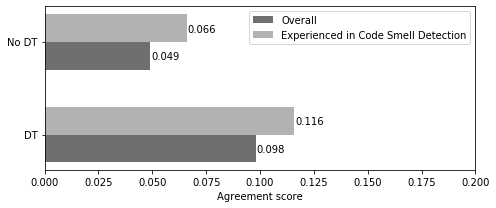

None

In [20]:
display(df_kappa_csmell)

display(pd.DataFrame([[0.000367,0.442],[0.549 ,0.0291]])) #p-values

display(plotBarh(df_kappa_overall.Avg,df_kappa_csmell.Avg,'Experienced in Code Smell Detection'))

## Experienced Java programming

In [21]:
answer_no_dummy_java=answer_no_dummy[answer_no_dummy.javaExperience.isin([2,3,4])]

# retira alguns participantes para equalizar o quadrado latino
#answer_no_dummy_java = answer_no_dummy_java[~answer_no_dummy_java.inviteId.isin(['aadeab9473','98ade17f7a'])]

df_kappaTable_dt, df_kappaTable_noDt, df_kappa_java, eval_matrix_p1_dt, eval_matrix_p2_dt, eval_matrix_p1_noDt, eval_matrix_p2_noDt = build(answer_no_dummy_java)

#exporta a matriz de evaluations em csv
eval_matrix_p1_dt.to_csv("csv_evaluation_matrix/java_agreement_eval_matrix_p1_dt.csv", header=False, index=False)
eval_matrix_p2_dt.to_csv("csv_evaluation_matrix/java_agreement_eval_matrix_p2_dt.csv", header=False, index=False)
eval_matrix_p1_noDt.to_csv("csv_evaluation_matrix/java_agreement_eval_matrix_p1_noDt.csv", header=False, index=False)
eval_matrix_p2_noDt.to_csv("csv_evaluation_matrix/java_agreement_eval_matrix_p2_noDt.csv", header=False, index=False)

df_kappaTable_dt

,Task Group,Task ID,CS,Disagree,Agree
0,1,3,gc,0,10
1,1,4,lm,1,9
6,1,11,lpl,0,10
4,1,7,rb,4,6
5,2,8,gc,1,11
3,2,6,lm,1,11
7,2,12,lpl,4,8
2,2,5,rb,5,7


In [22]:
df_kappaTable_noDt

,Task Group,Task ID,CS,Disagree,Agree
0,1,3,gc,2,10
1,1,4,lm,0,12
6,1,11,lpl,3,9
4,1,7,rb,4,8
5,2,8,gc,0,10
3,2,6,lm,2,8
7,2,12,lpl,7,3
2,2,5,rb,3,7


,Task_Group_1,Task_Group_2,Avg
DT,0.52,-0.143,0.189
noDT,NaN,0.314,NaN


,0,1
0,0.000367,0.4420
1,0.549000,0.0291


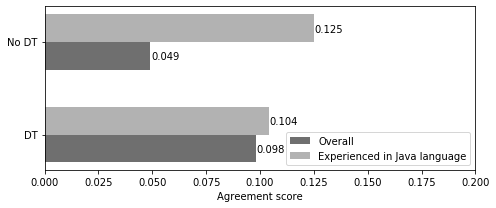

None

In [23]:
display(df_kappa_values)

display(pd.DataFrame([[0.000367,0.442],[0.549 ,0.0291]])) #p-values

display(plotBarh(df_kappa_overall.Avg,df_kappa_java.Avg,'Experienced in Java language'))

## Agreement by experience: development

In [24]:
answer_no_dummy_devExperience=answer_no_dummy[answer_no_dummy.devExperience.isin([2,3,4])]

# retira alguns participantes para equalizar o quadrado latino
#answer_no_dummy_devExperience = answer_no_dummy_devExperience[~answer_no_dummy_devExperience.inviteId.isin(['aadeab9473','a4fdb1f70d'])]

df_kappaTable_dt, df_kappaTable_noDt, df_kappa_development, eval_matrix_p1_dt, eval_matrix_p2_dt, eval_matrix_p1_noDt, eval_matrix_p2_noDt = build(answer_no_dummy_devExperience)

eval_matrix_p1_dt.to_csv("csv_evaluation_matrix/dev_agreement_eval_matrix_p1_dt.csv", header=False, index=False)
eval_matrix_p2_dt.to_csv("csv_evaluation_matrix/dev_agreement_eval_matrix_p2_dt.csv", header=False, index=False)
eval_matrix_p1_noDt.to_csv("csv_evaluation_matrix/dev_agreement_eval_matrix_p1_noDt.csv", header=False, index=False)
eval_matrix_p2_noDt.to_csv("csv_evaluation_matrix/dev_agreement_eval_matrix_p2_noDt.csv", header=False, index=False)

df_kappaTable_dt

,Task Group,Task ID,CS,Disagree,Agree
0,1,3,gc,1,13
1,1,4,lm,1,13
6,1,11,lpl,0,14
4,1,7,rb,5,9
5,2,8,gc,2,12
3,2,6,lm,2,12
7,2,12,lpl,5,9
2,2,5,rb,7,7


In [25]:
df_kappaTable_noDt

,Task Group,Task ID,CS,Disagree,Agree
0,1,3,gc,2,12
1,1,4,lm,0,14
6,1,11,lpl,4,10
4,1,7,rb,3,11
5,2,8,gc,1,13
3,2,6,lm,3,11
7,2,12,lpl,7,7
2,2,5,rb,5,9


,Task_Group_1,Task_Group_2,Avg
DT,0.52,-0.143,0.189
noDT,NaN,0.314,NaN


,0,1
0,0.0388,0.399
1,0.8160,0.271


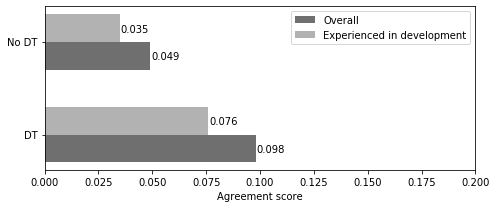

None

In [26]:
display(df_kappa_values)

display(pd.DataFrame([[0.0388,0.399],[0.816 ,0.271]])) #p-values

display(plotBarh(df_kappa_overall.Avg,df_kappa_development.Avg,'Experienced in development'))

## Evaluation effort

In [27]:

# answer_dt = answer_no_dummy[answer_no_dummy.isDt==1]
# answer_noDt = answer_no_dummy[answer_no_dummy.isDt==0]

# labels = ['DT', 'No DT']

# answerDtMinutes = answer_dt.secondsToAnswer/60
# answerNoDtMinutes = answer_noDt.secondsToAnswer/60

# all_data = [answerDtMinutes.tolist(),answerNoDtMinutes.tolist()]

# df_time_required = pd.DataFrame(all_data)
# df_time_required = df_time_required.T
# df_time_required.columns = labels

# # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
# #     display(df_time_required)

# import matplotlib.pyplot as plt

# ## combine these different collections into a list
# data_to_plot = all_data

# #plt.style.use('bmh')
# plt.style.use('seaborn-notebook')
# #plt.style.use('fivethirtyeight')
# #plt.style.use('seaborn-deep')

# # Create a figure instance
# fig = plt.figure()

# # Create an axes instance
# ax = fig.add_axes([0,0,1,1])

# # Create the violinplot
# bp = ax.violinplot(data_to_plot)
# for plot in bp['bodies']:
#     plot.set_facecolor('#66ccff')
#     plot.set_edgecolor('black')
#     plot.set_alpha(1)

# ax.get_xaxis().set_tick_params(direction='out')
# ax.xaxis.set_ticks_position('bottom')
# ax.set_xticks(np.arange(1, len(labels) + 1))
# ax.set_xticklabels(labels)
# ax.set_xticklabels(labels)
# ax.set_ylabel('Minutes')

# plt.show()



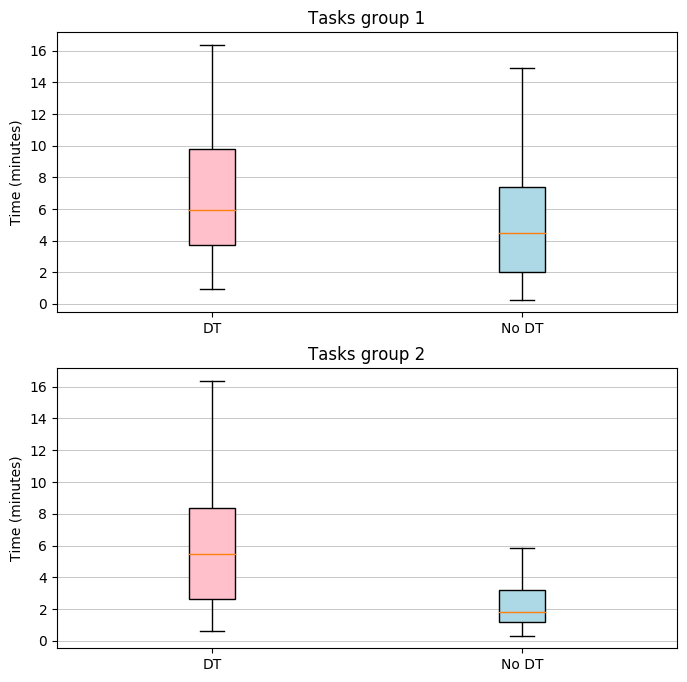

In [28]:
import matplotlib.pyplot as plt

g1 = [3,4,11,7] # o grupo de task determina se o participante foi P1 ou P2
g2 = [8,6,12,5]

answers_g1 = answer_no_dummy[answer_no_dummy.task_id.isin(g1)]
answers_g2 = answer_no_dummy[~answer_no_dummy.task_id.isin(g1)]

answers_g1_dt = answers_g1[answers_g1.isDt==1]
answers_g1_noDt = answers_g1[answers_g1.isDt==0]
answerG1DtMinutes = answers_g1_dt.secondsToAnswer/60
answerG1NoDtMinutes = answers_g1_noDt.secondsToAnswer/60

answers_g2_dt = answers_g2[answers_g2.isDt==1]
outliers = answers_g2_dt[(answers_g2_dt.secondsToAnswer/60)>45]
answers_g2_dt = answers_g2_dt.drop(outliers.index) #retirada de um outliers exagerado
answers_g2_noDt = answers_g2[answers_g2.isDt==0]
answerG2DtMinutes = answers_g2_dt.secondsToAnswer/60
answerG2NoDtMinutes = answers_g2_noDt.secondsToAnswer/60

labels = ['DT', 'No DT']

all_data = [answerG1DtMinutes.tolist(),answerG1NoDtMinutes.tolist()]

# df_time_required = pd.DataFrame(all_data)
# df_time_required = df_time_required.T
# df_time_required.columns = labels

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(df_time_required)



## combine these different collections into a list
data_to_plot = all_data

plt.style.use('default')
#plt.style.use('seaborn-notebook')
#plt.style.use('fivethirtyeight')
#plt.style.use('seaborn-deep')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# Create a figure instance
#fig = plt.figure()

# Create an axes instance
#ax = fig.add_axes([0,0,1,1])

# notch shape box plot
bplot1 = axes[0].boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels, showfliers=False)  # will be used to label x-ticks
axes[0].set_title('Tasks group 1')


all_data = [answerG2DtMinutes.tolist(),answerG2NoDtMinutes.tolist()]
bplot2 = axes[1].boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels, showfliers=False)  # will be used to label x-ticks
axes[1].set_title('Tasks group 2')


# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True, linestyle='-',linewidth=0.5)    
    ax.set_ylabel('Time (minutes)')
    
# fill with colors
colors = ['pink', 'lightblue']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# Create the violinplot
# bp = ax.violinplot(data_to_plot)
# for plot in bp['bodies']:
#     plot.set_facecolor('#66ccff')
#     plot.set_edgecolor('black')
#     plot.set_alpha(1)

# ax.get_xaxis().set_tick_params(direction='out')
# ax.xaxis.set_ticks_position('bottom')
# ax.set_xticks(np.arange(1, len(labels) + 1))
# ax.set_xticklabels(labels)
# ax.set_xticklabels(labels)
# ax.set_ylabel('Minutes')



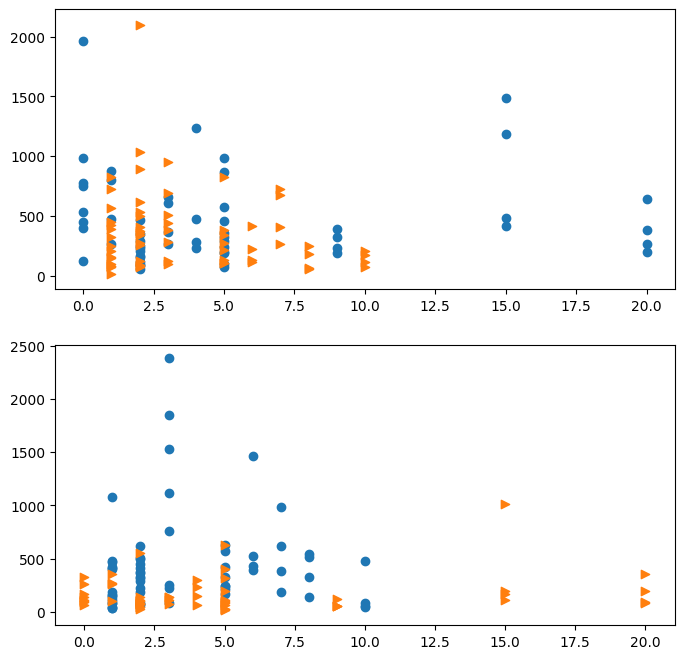

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))


scatter1 = axes[0].scatter(answers_g1_dt['yearsDevExperience'], answers_g1_dt['secondsToAnswer'])
scatter2 = axes[0].scatter(answers_g1_noDt['yearsDevExperience'], answers_g1_noDt['secondsToAnswer'], marker='>')
scatter3 = axes[1].scatter(answers_g2_dt['yearsDevExperience'], answers_g2_dt['secondsToAnswer'])
scatter4 = axes[1].scatter(answers_g2_noDt['yearsDevExperience'], answers_g2_noDt['secondsToAnswer'], marker='>')

#axes[0].set_title('Tasks group 1')

#plt.scatter(answer_dt['yearsDevExperience'], answer_dt['secondsToAnswer'])

In [30]:
import scipy.stats as stats

list_g1_dt = answers_g1_dt['secondsToAnswer']
list_g1_noDt = answers_g1_noDt['secondsToAnswer']

list_g2_dt = answers_g2_dt['secondsToAnswer']
list_g2_noDt = answers_g2_noDt['secondsToAnswer']

# stats.f_oneway(list_g1_dt, list_g1_noDt)

# stats.f_oneway(list_g2_dt, list_g2_noDt)

welchs = stats.ttest_ind(list_g1_dt, list_g1_noDt)
welchs = stats.ttest_ind(list_g2_dt, list_g2_noDt)

welchs


Ttest_indResult(statistic=4.195271475282236, pvalue=5.330526433083686e-05)

## Confidence

In [31]:
# # pega o dataframe completo de answers equalizado (mesma quantidade de participantes nos dois rows)
# answer_no_dummy = answer_no_dummy_overall.copy()

# answer_no_dummy.answer_csagreement = abs(answer_no_dummy.answer_csagreement)

# answer_dt = answer_no_dummy[answer_no_dummy.isDt==1]
# answer_noDt = answer_no_dummy[answer_no_dummy.isDt==0]

# labels = ['DT', 'No DT']

# sum_dt_strong = sum(answer_dt.answer_csagreement.isin([2,-2]))
# sum_dt_slight = sum(answer_dt.answer_csagreement.isin([1,-1]))
# sum_noDt_strong = sum(answer_noDt.answer_csagreement.isin([2,-2]))
# sum_noDt_slight= sum(answer_noDt.answer_csagreement.isin([1,-1]))

# df_confidence = pd.DataFrame([[sum_dt_strong, sum_dt_slight],[sum_noDt_strong, sum_noDt_slight]])
# df_confidence.index=labels
# df_confidence.columns = ['Strong dis(agreement)','Slight dis(agreement)']


# df_confidence



In [32]:
g1 = [3,4,11,7] # o grupo de task determina se o participante foi P1 ou P2
g2 = [8,6,12,5]

answers_g1 = answer_no_dummy[answer_no_dummy.task_id.isin(g1)]
answers_g2 = answer_no_dummy[~answer_no_dummy.task_id.isin(g1)]

answers_g1_dt = answers_g1[answers_g1.isDt==1]
answers_g1_noDt = answers_g1[answers_g1.isDt==0]

display(pd.DataFrame([[sum(answers_g1_dt.answer_csagreement==-2),
             sum(answers_g1_dt.answer_csagreement==-1),
             sum(answers_g1_dt.answer_csagreement==1),
             sum(answers_g1_dt.answer_csagreement==2)],
             [sum(answers_g1_noDt.answer_csagreement==-2),
             sum(answers_g1_noDt.answer_csagreement==-1),
             sum(answers_g1_noDt.answer_csagreement==1),
             sum(answers_g1_noDt.answer_csagreement==2)]], columns=['Strongly disagree', 'Disagree', 'Agree', 'Strongly agree'], index=['DT', 'No DT']
             ))


answers_g2_dt = answers_g2[answers_g2.isDt==1]
answers_g2_noDt = answers_g2[answers_g2.isDt==0]

display(pd.DataFrame([[sum(answers_g2_dt.answer_csagreement==-2),
             sum(answers_g2_dt.answer_csagreement==-1),
             sum(answers_g2_dt.answer_csagreement==1),
             sum(answers_g2_dt.answer_csagreement==2)],
             [sum(answers_g2_noDt.answer_csagreement==-2),
             sum(answers_g2_noDt.answer_csagreement==-1),
             sum(answers_g2_noDt.answer_csagreement==1),
             sum(answers_g2_noDt.answer_csagreement==2)]], columns=['Strongly disagree', 'Disagree', 'Agree', 'Strongly agree'], index=['DT', 'No DT']
             ))


,Strongly disagree,Disagree,Agree,Strongly agree
DT,3,4,18,31
No DT,2,9,10,43


,Strongly disagree,Disagree,Agree,Strongly agree
DT,11,8,10,35
No DT,4,12,8,32


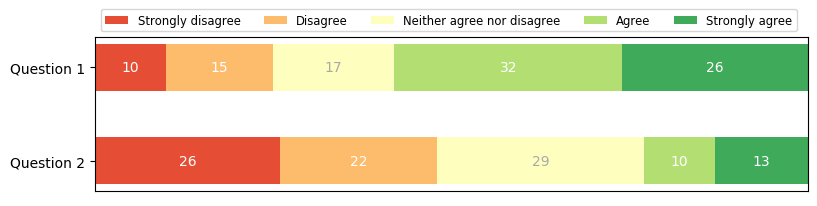

In [33]:
category_names = ['Strongly disagree', 'Disagree',
                  'Neither agree nor disagree', 'Agree', 'Strongly agree']
results = {
    'Question 1': [10, 15, 17, 32, 26],
    'Question 2': [26, 22, 29, 10, 13],    
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 2))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


survey(results, category_names)
plt.show()

## Open Questions

In [34]:
#relação de code smells e o código das atividades
df_codeSmells = pd.DataFrame([[3,4,5,6,7,8,11,12],['gc','lm','rb','lm','rb','gc','lpl','lpl']])
df_codeSmells = df_codeSmells.T
df_codeSmells.columns = ['task_id','cs']    


answer_to_excel = pd.merge(answer_no_dummy,df_codeSmells,on='task_id')

answer_to_excel.to_excel('answers.xls')

len(answer_to_excel.index)



240